In [1]:
import os, sys
import numpy as np
import pandas as pd
# To be run on desc-stack kernel
# I import my own version of GCR-Catalogs here, but
# you can use any version that has the latest Object and Source catalogs
sys.path.insert(0, '/global/homes/j/jwp/DC2/gcr-catalogs')
import GCRCatalogs
print(GCRCatalogs.__file__)
from astropy.coordinates import SkyCoord, matching
import astropy.units as u
%load_ext autoreload
%autoreload 2

/global/homes/j/jwp/DC2/gcr-catalogs/GCRCatalogs/__init__.py


### Matching Source and Object catalogs back to truth

Truth matching will only be applied to the objects. This means the sources that did not get matched to objects will not be matched to the truth.

The "truth" is the union of galaxies in `proto-dc2_v3.0` (on which Run 1.2i was based) and `dc2_truth_run1.2_static`. We include the truth catalog for the stars that are not in the extragalactic catalog.

In [2]:
# Fetch protoDC2 with the columns we need, restricted to our area
extragal_gcr = GCRCatalogs.load_catalog('proto-dc2_v3.0_test') # _test skips the md5 check
# 'cosmoDC2_v1.0_image' takes ~14 sec
extragal_quantities = ['galaxy_id', 'ra_true', 'dec_true', 'redshift_true', 
                      'size_bulge_true', 'size_minor_bulge_true', 'sersic_bulge', 'ellipticity_1_bulge_true',
                      'ellipticity_2_bulge_true', 'ellipticity_bulge_true',
                      'size_disk_true', 'size_minor_disk_true', 'sersic_disk', 'ellipticity_1_disk_true',
                      'ellipticity_2_disk_true', 'ellipticity_disk_true',
                      'bulge_to_total_ratio_i',
                      'mag_true_u_lsst',
                      'mag_true_g_lsst',
                      'mag_true_r_lsst',
                      'mag_true_i_lsst',
                      'mag_true_z_lsst',
                      'mag_true_Y_lsst',
                      'halo_mass',]
galaxies_dict = extragal_gcr.get_quantities(extragal_quantities, filters=[])
galaxies = pd.DataFrame(galaxies_dict, index=None)
print(galaxies.shape)

/global/homes/j/jwp/DC2/gcr-catalogs/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(9211556, 24)


In [3]:
# Find which ra, dec box corresponds to Tract 4850  
from skymap_utils import get_tract_corners
corners = get_tract_corners(tract_id=4850)

tract 4850 has corners (56.410, -29.783), (54.618, -29.783), (54.631, -28.228), (56.397, -28.228) (RA, Dec deg) and 7 x 7 patches


In [4]:
min_ra, min_dec = np.min(corners, axis=0)
max_ra, max_dec = np.max(corners, axis=0)
buffer = 0.1 # deg

54.61796844024866 56.41000495205823


In [5]:
# Fetch truth with the columns we need, restricted to our area
truth_gcr = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')
truth_quantities = ['object_id', 'sprinkled', 'star', 'agn', 'ra', 'dec', 'redshift'] + list('ugrizy') 
#print(sorted(truth_gcr.list_all_quantities(include_native=True)))
truth_filters = ['ra > %f' %(min_ra - buffer),
                'ra < %f' %(max_ra + buffer),
                'dec > %f' %(min_dec - buffer),
                'dec < %f' %(max_dec + buffer),]
truth_dict = truth_gcr.get_quantities(truth_quantities, native_filters=truth_filters)
truth_df = pd.DataFrame(truth_dict, index=None)

### Join extragalactic catalog with truth catalog
In the case of protoDC2, this step is necessary to rotate the protoDC2 field onto the DC2 field. Only galaxies will survive the join.

In [6]:
truth_extended = galaxies.merge(truth_df, how='inner', left_on='galaxy_id', right_on='object_id')

In [7]:
truth_extended.head()

,size_minor_bulge_true,size_minor_disk_true,sersic_disk,sersic_bulge,dec_true,ellipticity_1_bulge_true,ellipticity_2_bulge_true,galaxy_id,mag_true_r_lsst,halo_mass,...,star,r,agn,u,object_id,redshift,z,y,i,g
0,4.795085,6.225793,1.0,4.0,0.674109,0.343291,0.052789,7,11.619044,3.509520e+11,...,False,10.996866,True,12.220207,7,0.007052,10.614914,10.498124,10.762966,11.366055
1,1.092345,2.108287,1.0,4.0,1.231254,0.152970,0.256484,26,17.971756,1.164449e+11,...,False,17.925473,True,19.151460,26,0.012973,17.620158,17.562220,17.731668,18.259135
2,0.000000,1.940603,1.0,4.0,1.434664,NaN,NaN,52,17.932335,1.940749e+10,...,False,17.978307,False,19.625544,52,0.013717,17.656669,17.627993,17.747514,18.495268
3,0.743234,0.458977,1.0,4.0,0.813124,-0.123734,-0.148197,60,21.559978,3.072852e+10,...,False,21.543838,False,22.931867,60,0.020161,21.293254,21.272098,21.368731,21.894835
4,0.602066,0.393055,1.0,4.0,0.043271,-0.207849,-0.035678,80,19.943737,8.133354e+12,...,False,19.917222,True,21.029238,80,0.023965,19.757551,19.757425,19.806533,20.132630


In [8]:
# FIXME: IDK what's going on with the 3 star==True rows that got matched to protoDC2
print(truth_extended.shape)
truth_extended = truth_extended[truth_extended['star']==False]
print(truth_extended.shape)

(1155438, 37)
(1155435, 37)


### Save a subset of the truth catalog with just stars

In [10]:
truth_point = truth_df[truth_df['star']==True].copy()
print(truth_point.shape)

(34467, 13)


In [11]:
truth_combined = pd.concat([truth_extended, truth_point], axis=0, sort=False, ignore_index=True)

In [12]:
truth_combined.tail()

,size_minor_bulge_true,size_minor_disk_true,sersic_disk,sersic_bulge,dec_true,ellipticity_1_bulge_true,ellipticity_2_bulge_true,galaxy_id,mag_true_r_lsst,halo_mass,...,star,r,agn,u,object_id,redshift,z,y,i,g
1189897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,13.985789,False,15.269224,459361771,0.0,13.892980,13.895497,13.904412,14.253808
1189898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,20.261063,False,21.349933,1568792530,0.0,20.201078,20.213625,20.197302,20.491567
1189899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,20.072620,False,21.242134,1568792417,0.0,20.006028,20.014843,20.006405,20.308958
1189900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,17.453174,False,18.581434,834836,0.0,17.470917,17.477655,17.455468,17.552799
1189901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,True,14.353960,False,15.445417,834744,0.0,14.427729,14.435807,14.389338,14.405268


In [103]:
# Any cuts to improve matching

truth_combined = truth_combined[truth_combined['i'] < 26.0].reset_index()

In [13]:
truth_combined.to_csv('raw_data/truth_combined.csv', index=False)

In [14]:
truth_combined.columns.values

array(['size_minor_bulge_true', 'size_minor_disk_true', 'sersic_disk',
       'sersic_bulge', 'dec_true', 'ellipticity_1_bulge_true',
       'ellipticity_2_bulge_true', 'galaxy_id', 'mag_true_r_lsst',
       'halo_mass', 'size_bulge_true', 'redshift_true',
       'ellipticity_bulge_true', 'bulge_to_total_ratio_i',
       'mag_true_g_lsst', 'size_disk_true', 'mag_true_z_lsst',
       'mag_true_u_lsst', 'ellipticity_2_disk_true',
       'ellipticity_1_disk_true', 'ra_true', 'ellipticity_disk_true',
       'mag_true_i_lsst', 'mag_true_Y_lsst', 'ra', 'dec', 'sprinkled',
       'star', 'r', 'agn', 'u', 'object_id', 'redshift', 'z', 'y', 'i',
       'g'], dtype=object)

### Match using FoF

`FoFCatalogMatching.match` takes a dictionary of catalogs to match and a friends-of-friends linking length.

In [104]:
import FoFCatalogMatching

obj = pd.read_csv('raw_data/obj_opsim.csv', index_col=None)
#obj_skyCoord = SkyCoord(obj['ra'].values, obj['dec'].values, unit=(u.deg, u.deg))

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_combined, 'observed': obj},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

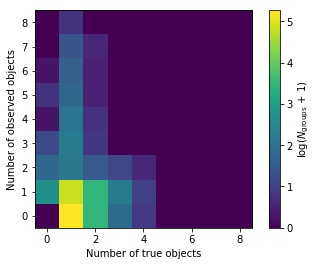

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

truth_mask = results['catalog_key'] == 'truth'
observed_mask = ~truth_mask

# Then, np.bincount will give up the number of id occurrences 
# (like histogram but with integer input):
n_groups = results['group_id'].max() + 1
n_true = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_observed = np.bincount(results['group_id'][observed_mask], minlength=n_groups)

# Now n_true and n_observed are the number of true/observed objects 
# in each group, and we want to make a 2d histogram of (n_true, n_observed). 
n_max = max(n_true.max(), n_observed.max()) + 1
hist_2d = np.bincount(n_observed * n_max + n_true, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of true objects');
plt.ylabel('Number of observed objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [52]:
one_to_one = hist_2d[1,1]
total = np.sum(hist_2d)
print(one_to_one, " out of ", total, "(%.3f) FoF groups are 1-to-1 matches." %(one_to_one/total))

70355  out of  260995 (0.270) FoF groups are 1-to-1 matches.


In [53]:
unobserved = hist_2d[0, 1]
print(unobserved, " out of ", total, "(%.3f) FoF groups are nondetections." %(unobserved/total))

183593  out of  260995 (0.703) FoF groups are nondetections.


In [54]:
blended = hist_2d[1, 2]
print(blended, " out of ", total, "(%.3f) FoF groups are blends." %(blended/total))

2909  out of  260995 (0.011) FoF groups are blends.


In [55]:
shredded = hist_2d[2, 1]
print(shredded, " out of ", total, "(%.3f) FoF groups are shreds." %(shredded/total))

120  out of  260995 (0.000) FoF groups are shreds.


In [56]:
### Evaluate matching from FoF

one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_true == 1) & (n_observed == 1)))
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
observed_idx = results['row_index'][one_to_one_group_mask & observed_mask]
true_matched = truth_combined.iloc[truth_idx].reset_index(drop=True)
observed_matched = obj.iloc[observed_idx].reset_index(drop=True)

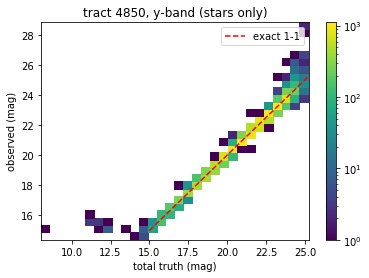

In [141]:
import matplotlib as mpl

band = 'y'
#truth_colname = 'mag_true_Y_lsst' #%band
truth_colname = band
observed_colname = 'mag_%s' %band
mask = ~np.logical_or(np.logical_or(np.isnan(true_matched[truth_colname]), np.isnan(observed_matched[observed_colname])), true_matched['star']==False)
plt.hist2d(true_matched[truth_colname].loc[mask], observed_matched[observed_colname].loc[mask],
           norm=mpl.colors.LogNorm(), bins=30) #marker='.', alpha=0.2, label='_nolegend_')
plt.plot(np.linspace(15, 30, 20), np.linspace(15, 30, 20), color='r', linestyle='--', label='exact 1-1')
plt.xlabel('total truth (mag)')
plt.ylabel('observed (mag)')
plt.title('tract 4850, %s-band (stars only)' %band)
plt.colorbar()
plt.legend()

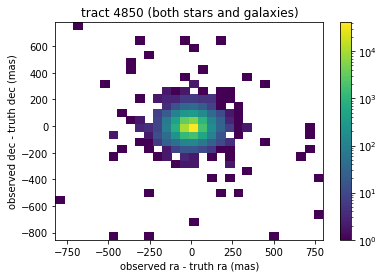

In [215]:
mask = np.ones(observed_matched.shape[0]).astype(bool)#true_matched['star']==False
_ = plt.hist2d((observed_matched['ra'].loc[mask] - true_matched['ra'].loc[mask])*3600.0*1000.0,
               (observed_matched['dec'].loc[mask] - true_matched['dec'].loc[mask])*3600.0*1000.0,
               norm=mpl.colors.LogNorm(), bins=30) #marker='.', alpha=0.2, label='_nolegend_')
plt.xlabel('observed ra - truth ra (mas)')
plt.ylabel('observed dec - truth dec (mas)')
plt.title('tract 4850 (both stars and galaxies)')
plt.colorbar()

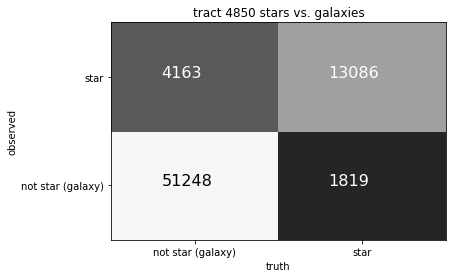

In [266]:
import matplotlib as mpl

#truth_colname = 'mag_true_Y_lsst' #%band
truth_colname = 'star'
observed_colname = 'extendedness'
mask = ~np.logical_or(np.isnan(true_matched[truth_colname]), 
                                    np.isnan(observed_matched[observed_colname]))
count, _, _, _ = plt.hist2d(true_matched[truth_colname].loc[mask].astype(int), np.logical_not(observed_matched[observed_colname].loc[mask]).astype(int),
           norm=mpl.colors.LogNorm(), bins=2, cmap=plt.cm.get_cmap("gray")) #marker='.', alpha=0.2, label='_nolegend_')
plt.xlabel('truth')
plt.ylabel('observed')
plt.title('tract 4850 stars vs. galaxies')
plt.xticks([0.25, 0.75], ('not star (galaxy)', 'star'))
plt.yticks([0.25, 0.75], ('not star (galaxy)', 'star'))

neg_x = 0.15 
pos_x = 0.65
plt.text(pos_x, 0.75, int(count[1, 1]), fontsize=16, color='white') # true positives
plt.text(neg_x, 0.75, int(count[0, 1]), fontsize=16, color='white') # false positives
plt.text(pos_x, 0.25, int(count[1, 0]), fontsize=16, color='white') # false negatives
plt.text(neg_x, 0.25, int(count[0, 0]), fontsize=16) # true negatives
#cbar = plt.colorbar()
plt.clim(1000, 60000)
#cbar.set_ticks([1.e3, 5.e3, 1.e4])
#cbar.set_ticklabels(['1e3', '5e3', '1e4'])

In [254]:
count

array([[51248.,  4163.],
       [ 1819., 13086.]])

In [62]:
true_matched.columns

Index(['index', 'size_minor_bulge_true', 'size_minor_disk_true', 'sersic_disk',
       'sersic_bulge', 'dec_true', 'ellipticity_1_bulge_true',
       'ellipticity_2_bulge_true', 'galaxy_id', 'mag_true_r_lsst', 'halo_mass',
       'size_bulge_true', 'redshift_true', 'ellipticity_bulge_true',
       'bulge_to_total_ratio_i', 'mag_true_g_lsst', 'size_disk_true',
       'mag_true_z_lsst', 'mag_true_u_lsst', 'ellipticity_2_disk_true',
       'ellipticity_1_disk_true', 'ra_true', 'ellipticity_disk_true',
       'mag_true_i_lsst', 'mag_true_Y_lsst', 'ra', 'dec', 'sprinkled', 'star',
       'r', 'agn', 'u', 'object_id', 'redshift', 'z', 'y', 'i', 'g'],
      dtype='object')

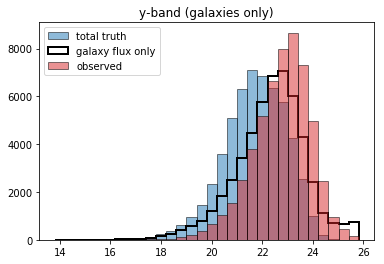

In [190]:
### Selection

band = 'y'
extragal_colname = 'mag_true_%s_lsst' %band if band != 'y' else 'mag_true_Y_lsst'
observed_colname = 'mag_%s' %band
mask = ~np.logical_or(np.logical_or(np.isnan(true_matched[band]), 
                                    np.isnan(observed_matched[observed_colname])), 
                      true_matched['star']==True) # True if only galaxies, False if only stars

plt.title('%s-band (galaxies only)' %band)
_, binning, _ = plt.hist(true_matched[band].loc[mask], bins=30, color='tab:blue', edgecolor='k', alpha=0.5, label='total truth')
_ = plt.hist(true_matched[extragal_colname].loc[mask], bins=binning, histtype='step', linewidth=2, color='k',  label='galaxy flux only')
_ = plt.hist(observed_matched[observed_colname].loc[mask], bins=binning, color='tab:red', edgecolor='k', alpha=0.5, label='observed')
plt.legend()

In [197]:
observed_matched.tail()

,ext_shapeHSM_HsmSourceMoments_yy,cModelFlux_g,y_ext_photometryKron_KronFlux_instFluxErr,r_ext_photometryKron_KronFlux_psf_radius,i_base_CircularApertureFlux_70_0_instFluxErr,Ixx_r,mag_y,ext_shapeHSM_HsmPsfMoments_flag,psFlux_flag_z,cModelFlux_flag_z,...,g_ext_photometryKron_KronFlux_instFlux,IyyPSF_u,z_base_CircularApertureFlux_70_0_instFluxErr,Ixy_i,m5_flux,PSF_sigma2,filtSkyBrightness_flux,airmass,dist2Moon,n_obs
70350,1.981698,77834.596597,4.997546,1.732065,15.316016,1.932830,18.269019,False,False,False,...,1329.152908,4.019762,25.927414,0.001251,0.193696,0.148814,55.483727,1.181620,1.536177,156
70351,2.604483,389.067824,4.492593,1.725996,15.726083,1.794986,24.038080,False,False,False,...,4.881749,4.039411,26.152872,-0.066163,0.055248,0.111953,13.155760,1.173847,1.828445,22
70352,1.992678,36127.984656,4.512781,1.714234,15.138306,1.892408,19.431205,False,False,False,...,606.940277,3.870175,26.864600,0.000498,0.190693,0.139774,56.251129,1.181865,1.530772,146
70353,2.037555,9761.168193,4.564365,1.711827,14.346139,1.905767,21.133376,False,False,False,...,169.563538,3.967412,27.021863,0.005169,0.171735,0.138277,50.504147,1.167943,1.549168,181
70354,1.915405,323239.479048,5.014742,1.791124,15.513031,2.090397,17.208531,False,False,False,...,5574.643573,3.801338,29.741796,0.007203,0.195640,0.144467,56.309982,1.188271,1.549313,151


In [198]:
obj_master = pd.merge(observed_matched, true_matched, left_index=True, right_index=True, suffixes=('_obs', '_truth'))
obj_master.to_csv('raw_data/obj_master.csv', index=None)

### Match using Astropy

In [34]:
truth_skyCoord = SkyCoord(truth_combined['ra'].values, truth_combined['dec'].values, unit=(u.deg, u.deg))

obj = pd.read_csv('raw_data/obj_opsim.csv', index_col=None)
obj_skyCoord = SkyCoord(obj['ra'].values, obj['dec'].values, unit=(u.deg, u.deg))

In [38]:
# Use astropy matching as in:
# https://github.com/LSSTDESC/DC2-production/blob/881125e14ff0cd5c4ea35b7725273369167cf98a/scripts/merge_source_cat.py#L292

matching_radius = 1.0 * u.arcsec
idx, sep2d, _ = matching.match_coordinates_sky(obj_skyCoord, truth_skyCoord)

In [39]:
def assign_truth_id(idx, sep2d, truth, matching_radius):
    is_fail = sep2d > matching_radius
    matched_truth = truth.iloc[idx]['object_id'].values.astype(int)
    matched_truth[is_fail] = -1
    return matched_truth

truth_ids = assign_truth_id(idx, sep2d, truth_combined, matching_radius)

In [41]:
obj['truth_id'] = truth_ids

In [49]:
# This many objects had a truth match
print(truth_ids[truth_ids>0].shape)

(85049,)

In [80]:
obj_master = obj.merge(truth_combined, how='inner', left_on='truth_id', right_on='object_id', suffixes=('_obs', '_truth'))
obj_master.to_csv('raw_data/obj_master.csv', index=None)

In [82]:
sorted(obj_master.columns.values)

['Ixx',
 'IxxPSF',
 'IxxPSF_g',
 'IxxPSF_i',
 'IxxPSF_r',
 'IxxPSF_u',
 'IxxPSF_y',
 'IxxPSF_z',
 'Ixx_g',
 'Ixx_i',
 'Ixx_r',
 'Ixx_u',
 'Ixx_y',
 'Ixx_z',
 'Ixy',
 'IxyPSF',
 'IxyPSF_g',
 'IxyPSF_i',
 'IxyPSF_r',
 'IxyPSF_u',
 'IxyPSF_y',
 'IxyPSF_z',
 'Ixy_g',
 'Ixy_i',
 'Ixy_r',
 'Ixy_u',
 'Ixy_y',
 'Ixy_z',
 'Iyy',
 'IyyPSF',
 'IyyPSF_g',
 'IyyPSF_i',
 'IyyPSF_r',
 'IyyPSF_u',
 'IyyPSF_y',
 'IyyPSF_z',
 'Iyy_g',
 'Iyy_i',
 'Iyy_r',
 'Iyy_u',
 'Iyy_y',
 'Iyy_z',
 'PSF_sigma2',
 'agn',
 'airmass',
 'bulge_to_total_ratio_i',
 'cModelFluxErr_g',
 'cModelFluxErr_i',
 'cModelFluxErr_r',
 'cModelFluxErr_u',
 'cModelFluxErr_y',
 'cModelFluxErr_z',
 'cModelFlux_flag_g',
 'cModelFlux_flag_i',
 'cModelFlux_flag_r',
 'cModelFlux_flag_u',
 'cModelFlux_flag_y',
 'cModelFlux_flag_z',
 'cModelFlux_g',
 'cModelFlux_i',
 'cModelFlux_r',
 'cModelFlux_u',
 'cModelFlux_y',
 'cModelFlux_z',
 'dec_obs',
 'dec_true',
 'dec_truth',
 'dist2Moon',
 'ellipticity_1_bulge_true',
 'ellipticity_1_disk_true',
 'e

### Match to Source